In [1]:
# Setting up the workspace by importing all of the necessary libraries.

import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, chi2


from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, r2_score, confusion_matrix,f1_score, recall_score, precision_score, make_scorer
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import BaggingClassifier
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn import svm


Using TensorFlow backend.


In [2]:
def cm(y_real, y_pred, t='test'):
    cf = confusion_matrix(y_real, y_pred)
    print(f"Confusion Matrix {t}: ")
    akws = {"ha": 'center',"va": 'top'}
    sns.heatmap(cf/(np.sum(cf)),annot=True, fmt='0.2%',cmap='Blues', annot_kws=akws, cbar=False)

    akws = {"ha": 'center',"va": 'bottom'}
    sns.heatmap(cf,annot=True, fmt='0',cmap='Blues', annot_kws=akws)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [3]:
df = pd.read_csv('DIQ010_Target.csv')
df.head()

,id,WTDRD1,WTDR2D,DR1DRSTZ,DRABF,DRDINT,DR1DAY,DBQ095Z,DBD100,DRQSPREP,...,DRD370R,DRD370RQ,DRD370S,DRD370SQ,DRD370T,DRD370TQ,DRD370U,DRD370UQ,DRD370V,DIQ010
0,73557,16888.327864,12930.890649,1,2.0,2.0,2.0,3.0,2.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,73558,17932.143865,12684.148869,1,2.0,2.0,1.0,1.0,2.0,3.0,...,2.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0,1.0
2,73559,59641.812930,39394.236709,1,2.0,2.0,6.0,1.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,73560,142203.069917,125966.366442,1,2.0,2.0,3.0,1.0,1.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,73561,59052.357033,39004.892993,1,2.0,2.0,1.0,4.0,0.0,4.0,...,2.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0


In [4]:
df.DIQ010.value_counts()

0.0    8392
1.0     888
Name: DIQ010, dtype: int64

In [5]:
X = df.drop(['DIQ010'], axis=1)
y = df['DIQ010']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2, random_state=81)

In [8]:
y_train.value_counts()


0.0    6729
1.0     695
Name: DIQ010, dtype: int64

In [9]:
rf = RandomForestClassifier()

In [10]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [11]:
train_pred = rf.predict(X_train)
test_pred = rf.predict(X_test)

Confusion Matrix test: 


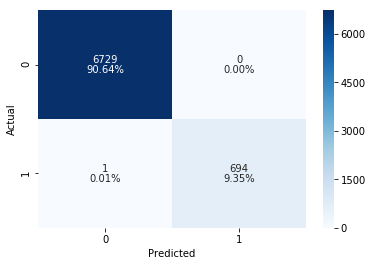

In [13]:
cm(y_train, train_pred)

In [14]:
print('Accuracy: ', precision_score(y_train, train_pred))

Accuracy:  1.0


Confusion Matrix test: 


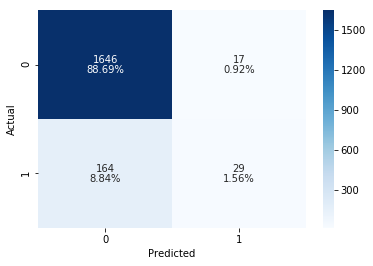

In [15]:
cm(y_test, test_pred)

In [16]:
print('Accuracy: ', precision_score(y_test, test_pred))

Accuracy:  0.6304347826086957


In [17]:
sm = SMOTE(n_jobs=-1)

In [18]:
X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train)

In [19]:
rf.fit(X_train_sm, y_train_sm)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [20]:
train_pred = rf.predict(X_train)
train_pred_sm = rf.predict(X_train_sm)
test_pred = rf.predict(X_test)

Confusion Matrix test: 


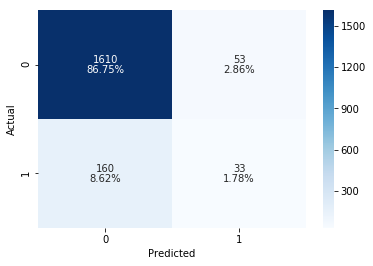

In [21]:
cm(y_test, test_pred)

In [27]:
print('Accuracy: ', precision_score(y_test, test_pred))

Accuracy:  0.38372093023255816


Confusion Matrix test: 


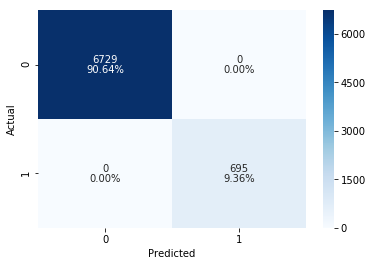

In [22]:
cm(y_train, train_pred)

In [28]:
print('Accuracy: ', precision_score(y_train, train_pred))

Accuracy:  1.0


Confusion Matrix test: 


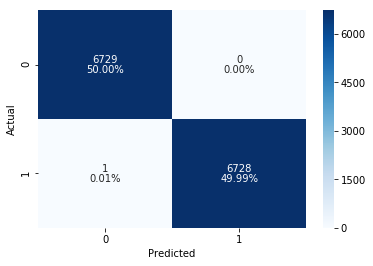

In [23]:
cm(y_train_sm, train_pred_sm)

In [24]:
print('Accuracy: ', precision_score(y_train_sm, train_pred_sm))

Accuracy:  1.0


# Finding the best model using recall as a metric

In [45]:
rf = RandomForestClassifier()

params = {"n_estimators":[10, 20, 50, 100],
          "criterion": ["entropy", "gini"],
          "max_depth": [1, 2, 5, 10]}

clf = GridSearchCV(rf, params, scoring=make_scorer(recall_score))

In [46]:
clf.fit(X_train_sm, y_train_sm)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              ra

In [47]:
clf.best_params_

{'criterion': 'gini', 'max_depth': 10, 'n_estimators': 100}

In [48]:
rf2 = RandomForestClassifier(n_estimators=100, max_depth=10, criterion='gini')

In [49]:
rf2.fit(X_train_sm, y_train_sm)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [50]:
train_pred2 = rf2.predict(X_train)
train_pred_sm = rf2.predict(X_train_sm)
test_pred2 = rf2.predict(X_test)

Confusion Matrix test: 


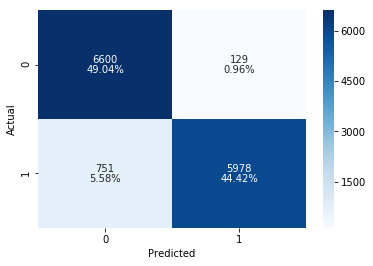

In [51]:
cm(y_train_sm, train_pred_sm)

In [53]:
print(classification_report(y_train_sm, train_pred_sm))

              precision    recall  f1-score   support

         0.0       0.90      0.98      0.94      6729
         1.0       0.98      0.89      0.93      6729

    accuracy                           0.93     13458
   macro avg       0.94      0.93      0.93     13458
weighted avg       0.94      0.93      0.93     13458



Confusion Matrix test: 


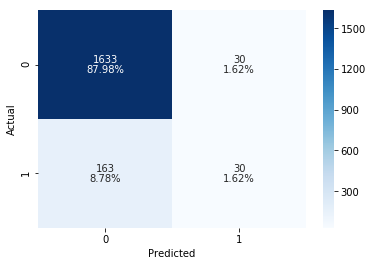

In [52]:
cm(y_test, test_pred2)

In [54]:
print(classification_report(y_test, test_pred))

              precision    recall  f1-score   support

         0.0       0.91      0.97      0.94      1663
         1.0       0.37      0.16      0.22       193

    accuracy                           0.88      1856
   macro avg       0.64      0.56      0.58      1856
weighted avg       0.85      0.88      0.86      1856



### Feature selection

In [37]:
select_feature = SelectKBest(chi2, k=5).fit(X_train_sm, y_train_sm)

In [40]:
select_feature_df = pd.DataFrame({'Feature':list(X_train.columns),
                                 'Scores': select_feature.scores_})
select_feature_df.sort_values(by='Scores', ascending=False )

,Feature,Scores
1,WTDRD1,707729.384118
72,DR1TMOIS,207859.004602
45,DR1TLZ,182992.559244
95,DR1BWATZ,182474.610768
93,DR1.320Z,97053.510968
42,DR1TBCAR,80001.200237
69,DR1TCAFF,73897.412589
2,WTDR2D,19021.191156
44,DR1TLYCO,16769.694960
60,DR1TCALC,13557.512913


In [55]:
X_train_chi = select_feature.transform(X_train_sm)
X_test_chi = select_feature.transform(X_test)

In [57]:
rf2.fit(X_train_chi, y_train_sm)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [58]:
train_pred_chi = rf2.predict(X_train_chi)
test_pred_chi = rf2.predict(X_test_chi)

Confusion Matrix test: 


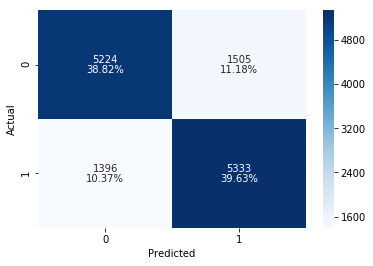

In [59]:
cm(y_train_sm, train_pred_chi)

In [60]:
print(classification_report(y_train_sm, train_pred_chi))

              precision    recall  f1-score   support

         0.0       0.79      0.78      0.78      6729
         1.0       0.78      0.79      0.79      6729

    accuracy                           0.78     13458
   macro avg       0.78      0.78      0.78     13458
weighted avg       0.78      0.78      0.78     13458



Confusion Matrix test: 


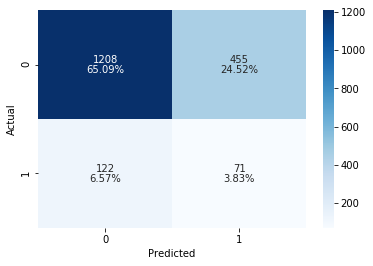

In [61]:
cm(y_test, test_pred_chi)

In [62]:
print(classification_report(y_test, test_pred_chi))

              precision    recall  f1-score   support

         0.0       0.91      0.73      0.81      1663
         1.0       0.13      0.37      0.20       193

    accuracy                           0.69      1856
   macro avg       0.52      0.55      0.50      1856
weighted avg       0.83      0.69      0.74      1856



In [65]:
dlist = []
for p in np.linspace(1, 5, 9):
    for n in [2, 3, 4, 5, 6,]:
        d = {}
        d['p'] = p
        d['n'] = n
        knn = KNeighborsClassifier(n_neighbors=n, p=p)
        knn.fit(X_train, y_train)
        score_test = knn.score(X_test, y_test)
        score_train = knn.score(X_train, y_train)
        score_ratio = min([score_train/score_test, score_test/score_train])
        d['score'] = score_test
        d['score_ratio'] = score_ratio
        dlist.append(d)
        
score_df = pd.DataFrame(dlist)
score_df.sort_values(by=['score_ratio', 'score'], ascending=False, inplace=True)
score_df.head(10)

,n,p,score,score_ratio
4,6,1.0,0.895474,0.987669
14,6,2.0,0.895474,0.986643
34,6,4.0,0.895474,0.986497
29,6,3.5,0.895474,0.986350
9,6,1.5,0.895474,0.986204
24,6,3.0,0.895474,0.986204
39,6,4.5,0.894935,0.986196
44,6,5.0,0.894935,0.986196
19,6,2.5,0.894935,0.985464
2,4,1.0,0.893858,0.983402


In [66]:
scaler = StandardScaler()
X_scaled_train = scaler.fit_transform(X_train)
X_scaled_test = scaler.transform(X_test)


In [67]:
knn = KNeighborsClassifier(n_neighbors=6, p=1)
knn.fit(X_scaled_train, y_train)

print(knn.score(X_scaled_test, y_test))

0.8976293103448276


In [ ]:
dlist = []
for p in np.linspace(1, 5, 9):
    for n in [2, 3, 4, 5, 6,]:
        d = {}
        d['p'] = p
        d['n'] = n
        knn = KNeighborsClassifier(n_neighbors=n, p=p)
        knn.fit(X_scaled_train, y_train)
        score_test = knn.score(X_scaled_test, y_test)
        score_train = knn.score(X_scaled_train, y_train)
        score_ratio = min([score_train/score_test, score_test/score_train])
        d['score'] = score_test
        d['score_ratio'] = score_ratio
        dlist.append(d)
        
score_df = pd.DataFrame(dlist)
score_df.sort_values(by=['score_ratio', 'score'], ascending=False, inplace=True)
score_df.head(10)